In [ ]:
import keras
keras.__version__

# Notebook 2

## Using Convolutional Neural Networks(CNNs) to identify dogs and cats: a binary classification problem

This notebook contains code samples that have been adapted from Francois Chollet's Deep Learning With Python.

----
In this notebook we are going to introduce how to build a Convolutional Neural Network using [convolutional](https://keras.io/layers/convolutional/) layers. We are going to introduce the following layers:
* `Conv2D`
* `MaxPooling`
* `Flatten`
* `Dropout` (You have seen a small introduction to this in the previous notebook.

We are also going to introduce training using Keras generator APIs such as `fit_generator`. Using Keras's `ImageDataGenerator` we will use image augmentation to fight overfitting.  

## Problem

In our example CNN model we will classify images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. We will introduce two techniques to train a model on small datasets:
* Data augmentation [improves accuracy from 71% to 82%]
* Feature extraction with a pre-trained network [improves accuracy to ~93%]

There is a third technique which can increase accuracy further. But we will not be covering this since it requires training on a GPU.
* Fine tuning a pre-trained network [improves accuracy to 95%]

## Dataset

You should have downloaded the cats vs dogs dataset from Kaggle as part of the Workshop setup instructions. If you haven't you can do so at this link: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [1]:
import os, shutil

In [7]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/media/mike/HDD/data/cats_and_dogs/train'

# The directory where we will
# store our smaller dataset
base_dir = '/media/mike/HDD/data/cats_and_dogs/small/'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our testing cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our testing dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [8]:
assert 1000 == len(os.listdir(train_cats_dir))
assert 1000 == len(os.listdir(train_dogs_dir))

assert 500 == len(os.listdir(validation_cats_dir))
assert 500 == len(os.listdir(validation_dogs_dir))

assert 500 == len(os.listdir(test_cats_dir))
assert 500 == len(os.listdir(test_dogs_dir))


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

The general structure of our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly: it will have 4 `Conv2D` + `MaxPooling2D` stages. 

A `Conv2D` layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. You can add a bias vector and activation to the output if needed. A `MaxPooling2D` layer is used to downscale input in
both the vertical and horizontal dimensions.

## Exercise 1: Build your model with Conv2D and MaxPooling2D layers

In [9]:
from keras import layers
from keras import models

# Instantiate a Sequential model
model = models.Sequential() 
# Add a Conv2D layer with 32 filters, kernel_size of (3, 3) and `relu` activation. 
# Given that this is the first layer you need to specify the input shape of the input 
# without the sample size axis. For example: (128, 128, 3) represents
# an input image of shape 128 X 128 RGB images and a data_format of "channels_last".
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer with a pool size of (2, 2).
model.add(layers.MaxPooling2D((2, 2)))
# Add a Conv2D layer with 64 filters, kernel_size of (3, 3) and `relu` activation.
# ...
# Add a MaxPooling2D layer with a pool size of (2, 2).
# ...
# Add a Conv2D layer with 128 filters, kernel_size of (3, 3) and `relu` activation.
# ...
# Add a MaxPooling2D layer with a pool size of (2, 2).
# ...
# Add a Conv2D layer with 128 filters, kernel_size of (3, 3) and `relu` activation.
# ...
# Add a MaxPooling2D layer with a pool size of (2, 2).
# ...
# Exercise 1: Solution
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

Using TensorFlow backend.


## Exercise 2: Add a Flatten layer followed by 2 Dense layers:
The next step would be to feed our last output tensor into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D using the `Flatten` layer and then add a few Dense layers on top to classify the image.

In [10]:
from keras import layers
from keras import models

# Use our model with Conv2D and MaxPooling2D layers from the previous section
# ...
# Add a Flatten layer
# ...
# Add a Dense layer of 512 units and `relu` activation.
# ...
# Add a Dense layer of 1 unit and `sigmoid` activation.

# Exercise 2: Solution
# Our model from the previous section
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# The newly added Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

## Compile the model:

In [12]:
from keras import optimizers

# `compile` the model using `binary_crossentropy` loss, `RMSProp` optimizer and 
# `accuracy` metric.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## ImageDataGenerator

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class [`ImageDataGenerator`](https://keras.io/preprocessing/image/) which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator.We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours.

## Exercise 3: Train the model using the `fit_generator` method:

We need the `steps_per_epoch` and `validation_steps` argument to specify the batches drawn from the generator since the generator yields data endlessly.
Note: To run through the entire input dataset, the `steps_per_epoch` argument should be num_inputs_samples/generator_batch_size = 2000/20 = 100.

In [15]:
# Train the model using the `fit_generator` method with the `train_generator` created 
# above as the first argument.
# The other parameters to this API are similar to the `fit` function.
# `steps_per_epoch` to specify the number of batches to draw from the generator.
# `epochs` that we want to train the model for.
# `validation_data` argument which will be the validation generator
# `validation_steps` to specify the number of batches to draw from the generator.
# history = model.fit_generator(...)

# Exercise 3: Solution
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
50/50 [==============================] - 105s 2s/step - loss: 0.6928 - acc: 0.5110 - val_loss: 0.6803 - val_acc: 0.5480
Epoch 2/30
50/50 [==============================] - 75s 1s/step - loss: 0.6807 - acc: 0.5640 - val_loss: 0.6592 - val_acc: 0.6230
Epoch 3/30
50/50 [==============================] - 71s 1s/step - loss: 0.6576 - acc: 0.6240 - val_loss: 0.6501 - val_acc: 0.6150
Epoch 4/30
50/50 [==============================] - 73s 1s/step - loss: 0.6408 - acc: 0.6390 - val_loss: 0.6524 - val_acc: 0.5790
Epoch 5/30
50/50 [==============================] - 79s 2s/step - loss: 0.6191 - acc: 0.6530 - val_loss: 0.6149 - val_acc: 0.6730
Epoch 6/30
50/50 [==============================] - 70s 1s/step - loss: 0.5975 - acc: 0.6730 - val_loss: 0.6104 - val_acc: 0.6620
Epoch 7/30
50/50 [==============================] - 74s 1s/step - loss: 0.5656 - acc: 0.6920 - val_loss: 0.6386 - val_acc: 0.6420
Epoch 8/30
50/50 [==============================] - 80s 2s/step - loss: 0.5710 - acc: 0.6

It is good practice to always save your models after training:

In [16]:
model.save('cats_and_dogs_small_1.h5')

Keras also provides APIs to load your model from an existing h5 file using `load`. You can also use the `save_weights` and `load_weights` APIs to only save/restore layer weights. 

Let's plot the loss and accuracy of the model over the training and validation data during training:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Verify that training accuracy increases linearly to reach almost 100%. Training loss should also decrease linearly until it reaches nearly 0.
Verify that validation accuracy stalls at 70-72% and validation loss reaches its minima after only 5 epochs and stalls.
These plots are characteristic of overfitting. 

We are now going to introduce the first technique to deal with overfitting, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

## Using Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

In [ ]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier.

## Exercise 4: Add a Dropout layer right before the fully connected Dense layers with a rate value of 0.5.

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# Add the Dropout layer with a dropout rate of 0.5
# ...
model.add(layers.Dropout(0.5))
# FCC Dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
# Compile your model using a `binary_crossentropy` loss, `RMPProp` 
# optimizer(learning rateis 1e-4) and `accuracy` as one of the metrics.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Let's train our network using data augmentation and dropout:

In [19]:
# Define our train ImageDataGenerator from above
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Define our test ImageDataGenerator
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Define parameters for batch generation from train data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Define parameters for batch generation from test data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# Train the model using `fit_generator`
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)
# Note you can train for steps_per_epoch=100 and epochs=100 to get an accuracy of 82%.
# However in the interest of time you can reduce the steps_per_epoch and number of epochs to
# 50 and 20 respectively.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
20/20 [==============================] - 49s 2s/step - loss: 0.6968 - acc: 0.5078 - val_loss: 0.6934 - val_acc: 0.4981
Epoch 2/20
20/20 [==============================] - 54s 3s/step - loss: 0.6905 - acc: 0.5279 - val_loss: 0.6891 - val_acc: 0.5019
Epoch 3/20
20/20 [==============================] - 49s 2s/step - loss: 0.6873 - acc: 0.5375 - val_loss: 0.6894 - val_acc: 0.4911
Epoch 4/20
20/20 [==============================] - 51s 3s/step - loss: 0.6893 - acc: 0.5234 - val_loss: 0.6792 - val_acc: 0.5247
Epoch 5/20
20/20 [==============================] - 59s 3s/step - loss: 0.6854 - acc: 0.5314 - val_loss: 0.6759 - val_acc: 0.5831
Epoch 6/20
20/20 [==============================] - 55s 3s/step - loss: 0.6861 - acc: 0.5422 - val_loss: 0.6968 - val_acc: 0.5019
Epoch 7/20
20/20 [==============================] - 58s 3s/step - loss: 0.6804 - acc: 0.5686 - val_loss: 0.6869 - val_acc: 0.5102
Epoch 

Let's plot our results again:

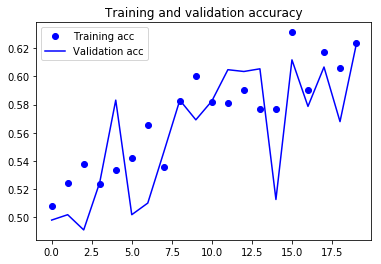

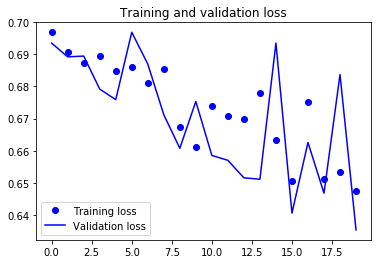

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Verify that the training and validation curves are closely tracking each other.
Verify that we can now reach an accuracy of 72% for 20 epochs with 50 steps per epoch.

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of ~72% if we train for 20 epochs. If we train for a 100 epochs we can achieve an accuracy of 82%, a 15% relative improvement over the non-regularized model.

In [22]:
## Exercise(optional): Use L2 regularization in our layers to see if we can achieve even better accuracy.

## Feature Extraction

The second technique that we will use to train an image classification model on a small dataset is Feature Extraction using a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet dataset(1.4 million labeled images and 1000 different classes). Keras comes prepackaged with a number of [image classification models](https://keras.io/applications/). VGG16 is one such model that is available as part of `keras.applications`. All the models are pre-trained on the ImageNet dataset.

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

Let's instantiate the VGG16 model:

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 555s 9us/step


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [ ]:
conv_base.summary()

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This involves running the convolutional base once for every input image. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/anjalisridhar/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

## Run the trained features through a Dense classifer:

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train the model using the extracted features and labels.
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU. You should have reached a validation accuracy of ~90% in 30 epochs.

Let's take a look at the loss and accuracy curves during training:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section (~84%) with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.


Another technique used to deal with small datasets is *Fine Tuning*. As mentioned in the beginning of the notebook, this technique is extremely slow and is practically impossible to run on CPU. You will need a GPU for this technique. You can create a `Sequential` model and add the `conv_base` as one of its layers. The output of the base is then flattened and run through a Dense fully connected network as we have seen before.

The steps for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.


We have already completed the first 3 steps when doing feature extraction. To proceed with the 4th step we will need to unfreeze our `conv_base`, and then freeze individual layers inside of it. You can set the `trainable` property of a layer as needed. 

Note: We need to first train the dense classifier we added to the pre-trained network before unfreezing the convolutional base. This is to prevent a large error signal from propagating through the network during training. The representations learned by the network previously will be destroyed otherwise.

In [ ]:
# Exercise 1: Solution
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))

In [ ]:
# Exercise 2: Solution
# Our model from the previous section
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# The newly added Flatten and Dense layers
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Exercise 3: Solution
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=50,
#       epochs=30,
#       validation_data=validation_generator,
#       validation_steps=50)

In [ ]:
# Exercise 4: Solution
# model.add(layers.Dropout(0.5))